# VAST And FINK Combined Lightcurve Plotting

This notebook is for Plotting the optical and radio variant sources side by side, as well as a starting point for seeing how to combine the data from both plots into one. This will involve some unit conversions (mag --> mJy, & Julian Date --> yyyy/mm/dd)

In [1]:
#here are the necessary imports
import os
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from io import StringIO

Now... for some mystical and magical reason, if you import vasttools BEFORE plotting the optical lightcurve, the optical plot wont show. I dont know why, I've triple checked this. So, when you go to execute the code in this notebook, you'll have to jump around the cells until we figure out why this bug is happening

In [2]:
cmf = pd.read_pickle('Fink_2020_sources_matched_to_VAST_all_sources.pickle')

In [3]:
AGN_Family=[
'AGN',
'AGN_Candidate',
'QSO',
'QSO_Candidate',
'Seyfert',
'Seyfert_1',
'Seyfert_2',
'Blazar',
'BLLac',
'Blazar_Candidate',
'RadioG',
'LINER'
]

Unknown_Family=[
'Unknown'
]

Galaxy_Family=[
'Galaxy',
'EmG',
'HII_G',
'GroupG',
'GinGroup',
'GinCl',
'GinPair',
'BClG',
'PartofG'
]

Stars_Family=[
'Star',
'RRLyr',
'Candidate_RRLyr',
'EB*',
'Candidate_EB*',
'WD*',
'LMXB',
'CataclyV*',
'low-mass*'
]

Supernovae_Family=[
'SN',
'SN candidate'
]

Radio_Family=[
'Radio',
'Radio(cm)'
]

Multiwavelength_Family=[
'Blue',
'UV',
'X'
]

Solar_System_Family=[
'Solar System',
'Solar System MPC',
'Solar System candidate',
]

In [4]:
Source_Families=[] #define an empty array
for i, row in cmf.iterrows(): #'i' represents the first index in cmf.iterrows, 'row' is the second
    x=row['class'] #this pulls out the class column from eachrow
    for j in AGN_Family: #for all the classes listed in the AGN family
        if x==j: #if it matches the class of the row
            Source_Families.append('AGN') #add 'AGN' to the empty array
    else: #otherwise, check the other families to see if it matches
        for j in Unknown_Family:
            if x==j:
                Source_Families.append('Unknown')
        else:
            for j in Galaxy_Family:
                if x==j:
                    Source_Families.append('Galaxy')
            else:
                for j in Stars_Family:
                    if x==j:
                        Source_Families.append('Star')
                else:
                    for j in Supernovae_Family:
                        if x==j:
                            Source_Families.append('Supernova')
                    else:
                        for j in Radio_Family:
                            if x==j:
                                Source_Families.append('Radio')
                        else:
                            for j in Multiwavelength_Family:
                                if x==j:
                                    Source_Families.append('Multiwavelength')
                            else:
                                for j in Solar_System_Family:
                                    if x==j:
                                        Source_Families.append('Solar System')
                                    
cmf['family']=Source_Families

In [31]:
#defining the photometry plotting function here to save having to rerun it everytime:

def plot_photometry(pdf):
    fig = plt.figure(figsize=(12, 5))

    colordic = {1: 'C0', 2: 'C1'}

    for filt in np.unique(pdf['i:fid']):
        maskFilt = pdf['i:fid'] == filt

        # The column `d:tag` is used to check data type
        maskValid = pdf['d:tag'] == 'valid'
        plt.errorbar(
            pdf[maskValid & maskFilt]['i:jd'].apply(lambda x: x - 2400000.5),
            pdf[maskValid & maskFilt]['i:magpsf'],
            pdf[maskValid & maskFilt]['i:sigmapsf'],
            ls = '', marker='o', color=colordic[filt]
        )

        maskUpper = pdf['d:tag'] == 'upperlim'
        plt.plot(
            pdf[maskUpper & maskFilt]['i:jd'].apply(lambda x: x - 2400000.5),
            pdf[maskUpper & maskFilt]['i:diffmaglim'],
            ls='', marker='^', color=colordic[filt], markerfacecolor='none'
        )

        maskBadquality = pdf['d:tag'] == 'badquality'
        plt.errorbar(
            pdf[maskBadquality & maskFilt]['i:jd'].apply(lambda x: x - 2400000.5),
            pdf[maskBadquality & maskFilt]['i:magpsf'],
            pdf[maskBadquality & maskFilt]['i:sigmapsf'],
            ls='', marker='v', color=colordic[filt]
        )

    plt.gca().invert_yaxis()
    plt.xlabel('Modified Julian Date')
    plt.ylabel('Magnitude')
    plt.show()

## So lets start with the optical preamble:

In [6]:
#retreiving object data for several objects at once using the objectId list (with upperlim):
Idlist=cmf['objectId'].to_list()

#defining column array for cutouts
cutouts=[
'b:cutoutScience_stampData',
'b:cutoutTemplate_stampData',
'b:cutoutDifference_stampData'
]

#this is the request made to the fink portal to pull out the info for each source
r = requests.post(
  'https://fink-portal.org/api/v1/objects',
  json={
    'objectId': 'ZTF18acetvcr',
    'output-format': 'json',
    'withcutouts': 'True',
    'cols': ','.join(cutouts),
    'withupperlim': 'True' #important for lightcurve plotting
  }
)

In [7]:
#reads in json file data as DataFrame. fsd stands for 'FINK source data'
fsd=pd.read_json(StringIO(r.content.decode()))

In [8]:
#This is fairly simple, we just specify a ZTF ID from our fsd list:
ID='ZTF18acetvcr'

#then define a new variable 'fsd_source, which is just all the rows in fsd such that the key 'i:objectId' is our ID of interest:
fsd_source=fsd[fsd['i:objectId'] == ID]

## Now, the radio preamble:

You will have to run this code AFTER you've plotted the optical lighcurve down below.

In [11]:
#This will automatically find the base directory that needed to be specified
pipe=Pipeline()
#this way, we can also load specific runs from the VAST pipeline:
my_run=pipe.load_run('tiles_corrected')

/opt/conda/lib/python3.9/site-packages/vasttools/pipeline.py:2609: UserWarning: Measurements have been loaded with vaex.
  warnings.warn("Measurements have been loaded with vaex.")


In [12]:
#this is the query string passed into the below function, which restricts the detected sources considered in the analysis. 
#Feel free to modify for different science goals.
my_query_string = (
    "n_measurements >= 3 "
    "& n_selavy >= 2 " # source finder ~ ML
    "& n_neighbour_dist > 1./60."
    "& 0.8 < avg_compactness < 1.4 "
    "& n_relations == 0"
    "& max_snr >= 5.0"
    "& v_peak > 0"
)

In [13]:
#Im just putting the eta and v threshholds because the eta-v analysis takes an actual eternity to complete and I already
#have the values here:
eta_thresh=2.315552652171963
v_thresh=0.2878888414273631

In [14]:
matched_ids=cmf['matched_id'].astype(int).to_list()

In [15]:
#this creates an arrray of sources from my_run that have the same ids as the catalogue, with the necessary eta and V information
#for the plot
sel=my_run.sources[my_run.sources.index.isin(matched_ids)]
print(len(sel))

1711


In [16]:
#we already got the VAST info on our crossmatched sources through sel. we just need to filter for the highly variable
#sources based on the eta and v threshholds we calculated before:
candidate_sel = sel[(sel['eta_peak'] >= eta_thresh) & (sel['v_peak'] >= v_thresh)]

#getting the sel_candidate ids is squirrely, since they're the row INDEX of the dataframe. 
#passing eta_v_candidates['id'] will not work. The below code pulls out those index values as a string list:
candidate_ids=candidate_sel.index.values.astype('str').tolist()

#then we just check how many objects in cmf have an id that match the candidate ids
candidate_cmf=cmf[cmf['matched_id'].isin(candidate_ids)]

## Candidate Selection and Plotting

In [21]:
candidate_cmf.query('family == "Radio"')

,objectId,matched_id,class,cdsxmatch,ra,dec,family
276,ZTF19aasqdci,3445010,Radio,Radio,190.376491,-7.281918,Radio
432,ZTF20aawijfi,3523466,Radio,Radio,300.994103,0.733969,Radio
549,ZTF19aadffas,3789407,Radio(cm),Radio(cm),160.937060,-6.482035,Radio
602,ZTF18abqsfre,3187458,Radio,Radio,19.576867,2.968363,Radio
704,ZTF20ablvrfp,3593756,Radio,Radio,316.483445,-9.200771,Radio
771,ZTF20aawiiij,3454483,Radio,Radio,301.121761,-2.152720,Radio
1083,ZTF19aaxpwdm,4065482,Radio,Radio,209.710834,-7.067122,Radio
1124,ZTF18acetvcr,4092797,Radio,Radio,349.989136,-5.115926,Radio
1238,ZTF19aarqoar,3716876,Radio(cm),Radio(cm),139.181793,-2.985775,Radio


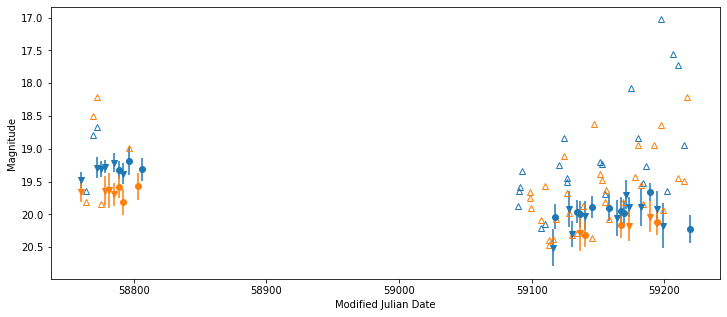

In [32]:
plot_photometry(fsd_source)

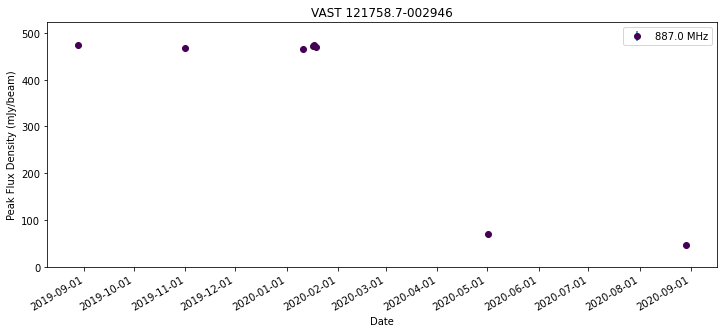

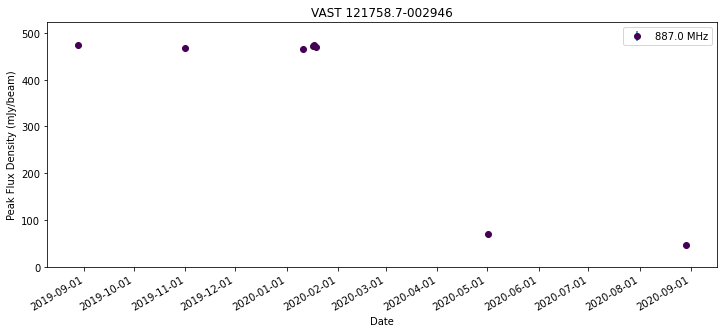

In [30]:
#getting info from specific source
vast_source=my_run.get_source(3989111)
#plotting the light curve of that specific source
vast_source.plot_lightcurve(figsize=(12,5))

In [10]:
from vasttools.pipeline import Pipeline
from vasttools.query import Query